## Importing Packages and Selecting a Device

In [1]:
# Importing required packages

from __future__ import print_function
import torch
import torch.nn as nn
import torch, torchvision
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy
from torchvision.utils import save_image

## Loading the Images

In [2]:
# Helper for visualization
def torch_imshow(img):
    # img = img.permute(1,2,0)
    plt.imshow(img.cpu().numpy())
    plt.show()

In [3]:
device = torch.device("cuda")

In [4]:
_transforms = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.Resize(size=(512, 512)),  # # scale imported image
        torchvision.transforms.ToTensor()  # transform it into a torch tensor
])

In [5]:
# Image Load
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = _transforms(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("/content/Style.jpg")
content_img = image_loader("/content/Content.jpg")

#Creating the generated image from the original image
generated_img = content_img.clone().requires_grad_(True)

In [6]:
print(content_img.size())

torch.Size([1, 3, 512, 512])


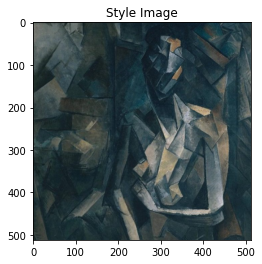

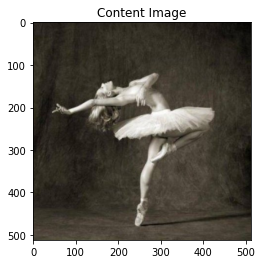

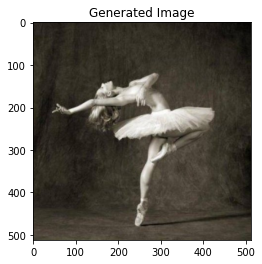

In [7]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)  

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(generated_img, title='Generated Image')

## Loss Functions

In [8]:
# Euclidean distance calculating between the features of content and generated image

def calc_content_loss(gen_feat,orig_feat):
    content_l = torch.mean((gen_feat-orig_feat)**2)
    return content_l

In [9]:
def calc_style_loss(generated,style):
    #Calculating the gram matrix for the style and the generated image
    batch_size,channel,height,width=generated.shape

    G_i_k = generated.view(channel,height*width)
    G_j_k = generated.view(channel,height*width)                 

    G = torch.mm(G_i_k, G_j_k.t())

    S_i_k = style.view(channel,height*width)
    S_j_k = style.view(channel,height*width)

    S = torch.mm(S_i_k ,S_j_k.t())
        
    #Calcultating the style loss of each layer by calculating the MSE between the gram matrix of the style image and the generated image and adding it to style loss
    style_l = torch.mean((G-S)**2)
    return style_l

In [10]:
def calculate_loss(generated_features, original_features, style_features):
    style_loss = 0
    content_loss = 0
    for generated,content,style in zip(generated_features,original_features,style_features):
        #extracting the dimensions from the generated image
        content_loss += calc_content_loss(generated,content)
        style_loss += calc_style_loss(generated,style)
    
    #calculating the total loss of e th epoch
    total_loss = a*content_loss + b*style_loss 
    return total_loss

## Feature Representations

In [11]:
#Defining a class that for the model
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()

        #Keeping only 5 convolutional layers
        # self.feature_indexes = ['0','5','10'] 
        # self.feature_indexes = ['0','5','10','19']
        self.feature_indexes = ['0','5','10','19','28']
        
        #Keeping only first 29 layers
        # self.model = models.vgg19(pretrained=True).features[:11] 
        # self.model = models.vgg19(pretrained=True).features[:20] 
        self.model = models.vgg19(pretrained=True).features[:29] 
    
   
    #x holds the input tensor(image) that will be feeded to each layer
    def forward(self,x):
        #initialize an array that wil hold the activations from the chosen layers
        features=[]
        #Iterate over all the layers of the mode
        for layer_num,layer in enumerate(self.model):
            #activation of the layer will stored in x
            x=layer(x)
            #appending the activation of the selected layers and return the feature array
            if (str(layer_num) in self.feature_indexes):
                features.append(x)
                
        return features

## Training

In [12]:
#Load the model to the GPU
model=VGG().to(device).eval() 

#initialize the paramerters required for fitting the model
a = 5
b = 100

#Defining an Adam optimizer with learning rate 0.001 to optimize the parameters of VGG
optimizer = optim.Adam([generated_img],lr = 0.001)
# optimizer = optim.SGD(model.parameters(),lr = 0.001)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [13]:
#Iterating for 100 times
epoch = 100
for i in range (epoch):
    #Extracting the features of generated, content and the style image
    generated_features=model(generated_img)
    content_feautes=model(content_img)
    style_featues=model(style_img)
    
    #iterating over the activation of each layer and calculate the loss and add it to the content and the style loss
    total_loss=calculate_loss(generated_features, content_feautes, style_featues)
    
    # Clear gradients
    optimizer.zero_grad()

    # Compute gradients using loss
    total_loss.backward()

    # Take a gradient descent step using optimizer
    optimizer.step()    
    
   
save_image(generated_img,"Generated.png")   

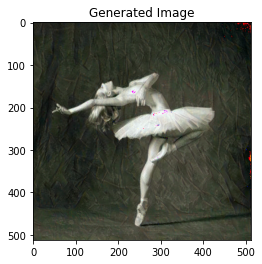

In [14]:
plt.figure()
imshow(generated_img, title='Generated Image')